# Visualisation: CE6003 Lab_4_3 (Optional)

This exercise is based on the paper by Manhendran (2015) https://arxiv.org/pdf/1512.02017.pdf

In this exercise the layers of the pre-trained VGG-16 network are to be visualised. 

Code has been included to load the model, display images and perform training.

Make sure you select the Runtime -> Change Runtime type -> GPU for faster computation.

For additionalinformation about visulisation & some nice images please view:  
https://distill.pub/2017/feature-visualization/?utm_campaign=Dynamically%20Typed&utm_medium=email&utm_source=Revue%20newsletter
 


In [49]:

#!pip install -q tensorflow==2.0.0-rc

from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import glob
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
print(tf.__version__)





2.0.0


# Input parameters.
For this exercise Let's focus on visualising the layer block3_conv2. This is a good compromise between nice images (See Figure 17) and faster execution compared to deeper layers. (you can experiment with modifying the notebook to observe the effect of the scaling factor C between the loss and regularisers. The jitter term T can also be varied. Other layers can also be visualised, this will required different values of C, H, W, T and n_c)

In [0]:


# Imagenet Rgb
imagenet_rgb_values = [123.68, 116.779, 103.939] # Preprocessing values for imagnet (no need to adjust)

# Loss function parameters from paper
B =  80
V = B/6.5
C = 5000 # Parmeter multiplies loss function value 
Z = 98000 #Estimated Scaling Value for loss block3_conv2
alpha_val = 6
beta_val = 2

# This selects the output layer we are going to visualise.
output_layer = ['block2_conv2'] 

H=40    #Input random noise image H
W=40    #Input random noise image W

T= 1     # Jitter value
n_c = 8  # centre neuron (depends on the number of down sampling stages to layer interest)

# Scalar for bounded range.
norm_r_alpha = 1/(H*W*(B**alpha_val))  # Alpha regulariser
# Scale for total variation regulation.
norm_r_beta  = 1/(H*W*(V**beta_val))  # Beta regulariser

In [0]:
# Helper function to output images at end/during optimisation
def display_image(image):
   
    title = ['Generated Image']
    plt.figure(figsize=(3,3))
    plt.title(title)
    plt.imshow(np.clip(image[0,:,:,:], 0, 255).astype("uint8"),aspect="auto")
    plt.axis('off')
    plt.show()

    
def display_array(img_array,array_size):
    #unprocess model input and output
    #p_low_res = unprocess_image(low_res_input)
    #up_model_op = unprocess_image(model_op)
    n = array_size[0]
    m = array_size[1]
    plt.figure(figsize=(3*m,3*n))
    plt.title('Imaged Filters') 
    ptr = 1
    for i in range(n):      
       for j in range(m):
          ax=plt.subplot(n,m,ptr)     
          plt.imshow(np.clip((img_array[ptr,:,:,:]+127.5), 0, 255).astype("uint8"),aspect="auto")  
          ptr = ptr+1
          plt.axis('off')
    plt.show()       

# Model Loading
The in-built keras VGG16 model will be loaded and visualised.
Additional processing function is required (to subtract mean from image)

In [0]:
# Load the Target model.
vgg16_model = tf.keras.applications.VGG16()

# keras implementation of Vgg19 (loaded below) requires preprocessing of input images and RGB->BGR
def process_image(input_img):
    op_img =[]
    r = input_img[:,:, :, 0] - imagenet_rgb_values[0]
    g = input_img[:,:, :, 1] - imagenet_rgb_values[1]
    b = input_img[:,:, :, 2] - imagenet_rgb_values[2]
    op_img = tf.stack([b,g,r],axis = 3)
    return op_img


A modified model "red_model" is created that has the same 224x224 input as Vgg16 but omits the layers after the layers of interest speeding up computation.




In [128]:


# Function to get layer output tensors & layer shapes.
def layer_data(layer_names):
    layer_shape = []  
    model_ops = []
    for layer in layer_names:
        model_ops.append(vgg16_model.get_layer(layer).output)
        layer_shape.append(vgg16_model.get_layer(layer).output_shape)
    return model_ops,layer_shape  

# Define reduced model
model_ops,output_layer_shape = layer_data(output_layer) 
red_model = tf.keras.Model(inputs = vgg16_model.input, outputs=model_ops ) 
print(output_layer_shape)

red_model.summary()

[(None, 112, 112, 128)]
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
____________________________

#Loss function & Regularisation:

In order to perform visualisation the correct loss function and regularisers (bounded range and bounded variation) from section 3 in the paper are implemented.  

Note that jitter can be implemented by a tensorflow function in the training step.



In [0]:
# Loss function due to activation maximisation.
def feat_loss(output_features):
    #loss = tf.keras.backend.mean(model_output[:, :, :, filter_index])
    loss = -(1/Z)*tf.math.reduce_sum(output_features[:, n_c, n_c, filter_index])
    return C*loss
    
    
# Add bouded range regulariser.
def bounded_rng_reg(img):
    #square all values
    x = tf.math.square(img)
    #sum over channels
    x = tf.keras.backend.sum(x,axis=3)
    #raise to a power
    x = tf.keras.backend.pow(x,alpha_val/2)
    #sum over remaining channels
    x=tf.math.reduce_sum(x)
    #apply scalar function.
    x = norm_r_alpha*x
    return x
  
  
# conditional value to bound the output  
#  Return on a per element basis, so that are gradients for each image value.
def cond_value(img):
    x = tf.math.square(img)
    x = tf.keras.backend.sum(x,axis=3)
    y = tf.keras.backend.pow(x,1/2)  
    return y
  
  
# Differences total variation loss
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  # Pad zeros along difference dimension for von neumann boundary. (dim reduced)
  pad_x = [[0,0],[0, 0], [0, 1],[0,0]]
  pad_y = [[0,0],[0, 1], [0, 0],[0,0]]      
  x_var = tf.pad(x_var, pad_x, 'CONSTANT', constant_values=0)
  y_var = tf.pad(y_var, pad_y, 'CONSTANT', constant_values=0)       
  return x_var, y_var


# Total variation loss
def TV_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  x = (x_deltas**2) + (y_deltas**2)
  x=(tf.keras.backend.pow(x,beta_val/2))
  x=tf.reduce_sum(x)
  tv_loss = norm_r_beta*x
  return tv_loss



# Combined losses
def total_loss(output_features,img):
    l1 =  feat_loss(output_features)
    l1_bnd =   bounded_rng_reg(img)
    tv_loss = TV_loss(img)
    t_loss =  l1+l1_bnd+tv_loss
    return l1,l1_bnd,t_loss,tv_loss


#Training Step
Note that the paper defines a specific stocasitic gradient descent algorithm, we can use the built in ADAM optimiser for convience.
Please note how jitter can be implemented (note it can be disabled, set jitter_on = False and T=0 in parameter list). it is recommended to not use jitter until you are satisfied you are getting images. The jitter slightly improves quallity. 

In [0]:
jitter_on = True
# optimiser for gradients
adam_optimiser = tf.keras.optimizers.Adam(0.1, beta_1=0.09, beta_2=0.99, epsilon=1e-7)


# Traing step function
def train_step(rnd_img_data):
  with tf.GradientTape() as gen_tape:
    
    gen_tape.watch(rnd_img_data)  
    if jitter_on == True:   
       inp_img = tf.image.random_crop(rnd_img_data,(1,H,W,3))
    else:
        inp_img = rnd_img_data
    op_features=red_model(process_image(inp_img+127.0))
    nx = np.max(cond_value(rnd_img_data))
    l1,l1_bnd,t_loss,tv_loss = total_loss(op_features,rnd_img_data)
 
  img_grads = gen_tape.gradient(t_loss,rnd_img_data)
  adam_optimiser.apply_gradients([(img_grads,rnd_img_data)])
  return l1,l1_bnd,t_loss,rnd_img_data,nx,tv_loss


# Complete Training
The two cells below contain two training loops. Use the first to debug any changes you make to the notebook as it will display images and loss values perodically.
Use the second to iterate over a few filters and plot the images similar to Figure 17 in the paper.

Note that before iteration a random noise image is applied to the input. The mean and standard deviation of this image must be set before training.

As metioned in the paper the value of C must be tuned to balance the loss against the regularisers. It may take some experimentation to find a good value of C if you have have made changes to the notebook and are trying to visualise other layers. 

Iteration Number = 0
Total loss = tf.Tensor(32.210453, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-0.0, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.027021369, shape=(), dtype=float32)
Total Variation = tf.Tensor(32.183434, shape=(), dtype=float32)
100.39691


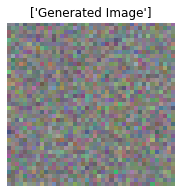

Iteration Number = 100
Total loss = tf.Tensor(-31.406902, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-46.890217, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.008839169, shape=(), dtype=float32)
Total Variation = tf.Tensor(15.474477, shape=(), dtype=float32)
86.33993


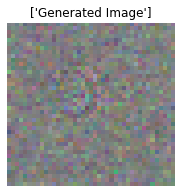

Iteration Number = 200
Total loss = tf.Tensor(-97.641, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-106.572624, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.008274845, shape=(), dtype=float32)
Total Variation = tf.Tensor(8.923348, shape=(), dtype=float32)
91.91104


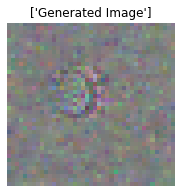

Iteration Number = 300
Total loss = tf.Tensor(-113.95666, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-120.61826, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.018175384, shape=(), dtype=float32)
Total Variation = tf.Tensor(6.6434307, shape=(), dtype=float32)
108.1698


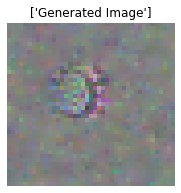

Iteration Number = 400
Total loss = tf.Tensor(-151.9093, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-158.28935, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.044471614, shape=(), dtype=float32)
Total Variation = tf.Tensor(6.3355885, shape=(), dtype=float32)
124.4205


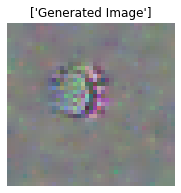

Iteration Number = 500
Total loss = tf.Tensor(-188.46016, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-195.65347, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.1043578, shape=(), dtype=float32)
Total Variation = tf.Tensor(7.0889583, shape=(), dtype=float32)
140.99025


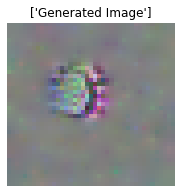

Iteration Number = 600
Total loss = tf.Tensor(-276.94647, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-285.64166, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.22786842, shape=(), dtype=float32)
Total Variation = tf.Tensor(8.467305, shape=(), dtype=float32)
156.53064


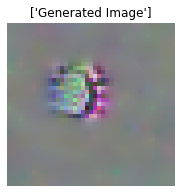

Iteration Number = 700
Total loss = tf.Tensor(-262.22174, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-272.84747, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.45677987, shape=(), dtype=float32)
Total Variation = tf.Tensor(10.1689415, shape=(), dtype=float32)
172.56215


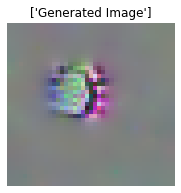

Iteration Number = 800
Total loss = tf.Tensor(-385.14465, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-398.08768, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(0.85046023, shape=(), dtype=float32)
Total Variation = tf.Tensor(12.092552, shape=(), dtype=float32)
187.68167


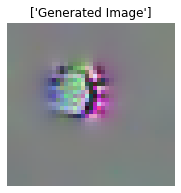

Iteration Number = 900
Total loss = tf.Tensor(-406.33044, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-421.97992, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(1.4951844, shape=(), dtype=float32)
Total Variation = tf.Tensor(14.1543045, shape=(), dtype=float32)
202.21028


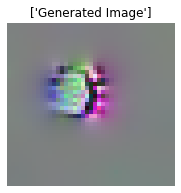

Iteration Number = 1000
Total loss = tf.Tensor(-471.83606, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-490.807, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(2.5182655, shape=(), dtype=float32)
Total Variation = tf.Tensor(16.45267, shape=(), dtype=float32)
215.60541


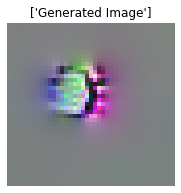

Iteration Number = 1100
Total loss = tf.Tensor(-491.82758, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-514.8449, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(4.062634, shape=(), dtype=float32)
Total Variation = tf.Tensor(18.95472, shape=(), dtype=float32)
229.56647


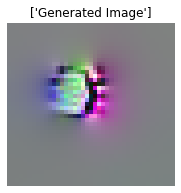

Iteration Number = 1200
Total loss = tf.Tensor(-554.1069, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-581.7691, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(6.235804, shape=(), dtype=float32)
Total Variation = tf.Tensor(21.42646, shape=(), dtype=float32)
240.36897


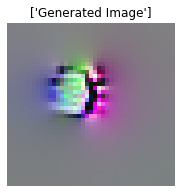

Iteration Number = 1300
Total loss = tf.Tensor(-593.13574, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-626.1972, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(9.181426, shape=(), dtype=float32)
Total Variation = tf.Tensor(23.880049, shape=(), dtype=float32)
249.06055


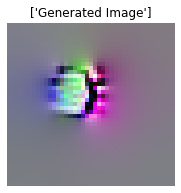

Iteration Number = 1400
Total loss = tf.Tensor(-604.7306, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-643.9689, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(12.985981, shape=(), dtype=float32)
Total Variation = tf.Tensor(26.252321, shape=(), dtype=float32)
261.64328


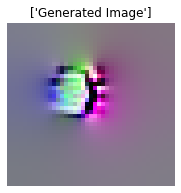

Iteration Number = 1500
Total loss = tf.Tensor(-532.50397, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-578.89105, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(17.785294, shape=(), dtype=float32)
Total Variation = tf.Tensor(28.60179, shape=(), dtype=float32)
275.51193


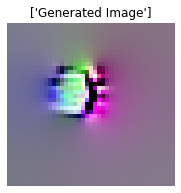

Iteration Number = 1600
Total loss = tf.Tensor(-560.2518, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-614.6381, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(23.595064, shape=(), dtype=float32)
Total Variation = tf.Tensor(30.791264, shape=(), dtype=float32)
288.76224


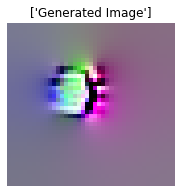

Iteration Number = 1700
Total loss = tf.Tensor(-723.05896, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-786.5397, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(30.524216, shape=(), dtype=float32)
Total Variation = tf.Tensor(32.95645, shape=(), dtype=float32)
299.7699


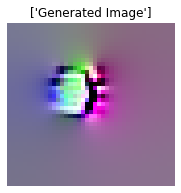

Iteration Number = 1800
Total loss = tf.Tensor(-608.06744, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-681.2542, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(38.420902, shape=(), dtype=float32)
Total Variation = tf.Tensor(34.76586, shape=(), dtype=float32)
311.50555


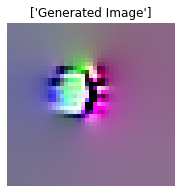

Iteration Number = 1900
Total loss = tf.Tensor(-773.89386, shape=(), dtype=float32)
Feature Maximisation = tf.Tensor(-857.95746, shape=(), dtype=float32)
Bounded regularisation = tf.Tensor(47.41671, shape=(), dtype=float32)
Total Variation = tf.Tensor(36.64693, shape=(), dtype=float32)
325.79175


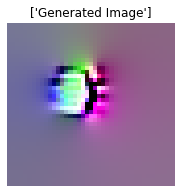

In [131]:
# Determine what image maximally stimulates a neuron

iterations = 2000
filter_index =1

# mean and stdev for input image noise vector.
mean_val = 0
std_val = 20.0

# initialise noise vector
rnd_img_data = tf.Variable( tf.random.normal([1, H+T,W+T,3],mean=mean_val,stddev=std_val,name="input_img_data"))
rnd_img_data = tf.cast(rnd_img_data, dtype='float32')

for iterations in range(iterations):
    l1,l1_bnd,t_loss,rnd_img_data,nx,tv_loss = train_step(rnd_img_data)
    if iterations % 100 == 0:
       print('Iteration Number =',iterations)
       print('Total loss =',t_loss)
       print('Feature Maximisation =',l1)
       print('Bounded regularisation =',l1_bnd)
       print('Total Variation =',tv_loss)
       print(nx)
       #print('Total Variation Loss=',tv_loss)
       display_image(rnd_img_data+127.0)

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


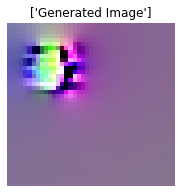

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


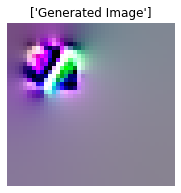

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


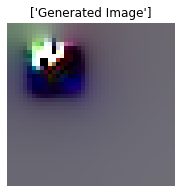

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


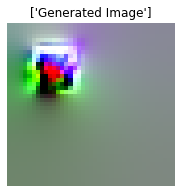

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


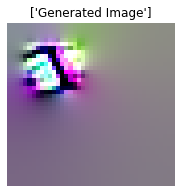

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


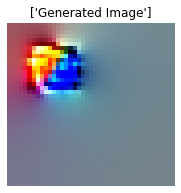

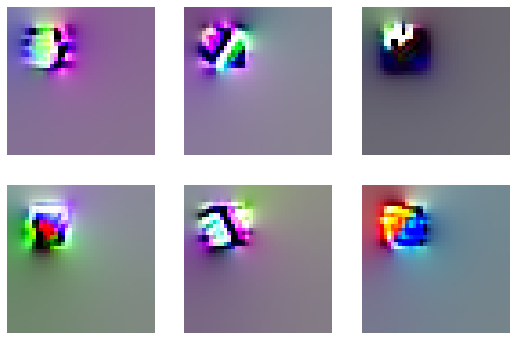

In [124]:
iterations = 2000
filter_list =[1,2,3,4,5,6]
#filter_list = list(range(0, 25))


mean_val = 0
std_val = 20.0

layer_images =  tf.Variable(np.zeros([1,H+T,W+T,3]))
layer_images = tf.cast(layer_images, dtype='float32')

# Code to produce multiple filter images in each layer.
for filter_index in filter_list:
    # reset random vector
    rnd_img_data = tf.Variable( tf.random.normal([1, H+T,W+T,3],mean=mean_val,stddev=std_val,name="input_img_data"))
    rnd_img_data = tf.cast(rnd_img_data, dtype='float32')
    
    for iterations in range(iterations):
        l1,l1_bnd,t_loss,rnd_img_data,nx,tv_loss = train_step(rnd_img_data)
        if iterations % 100 == 0:
          print('Iteration Number =',iterations)
    layer_images = tf.concat([layer_images, rnd_img_data],0) 
    display_image(rnd_img_data+127.0)
# reshape into grid and display.    
display_array(layer_images,(2,3))
#display_array(layer_images,(5,5))